<button onclick="
  var codes = document.querySelectorAll('.jp-CodeCell .jp-Cell-inputWrapper');
  var hidden = codes.length && window.getComputedStyle(codes[0]).display === 'none';
  codes.forEach(c => c.style.display = hidden ? 'block' : 'none');
  this.innerText = hidden ? 'Hide code' : 'Show code';
">Show code</button>

<style>
/* Hide only code inputs by default, not markdown */
.jp-CodeCell .jp-Cell-inputWrapper {
  display: none;
}
</style>

# Olist Brazilian E-Commerce Analysis

## Retail & Customer Analytics (2016–2018)

**Emilio Nahuel Pattini**  
Buenos Aires, Argentina  
February 01, 2026

## Table of Contents

- [1. Business Understanding & Questions](#1-business-understanding-questions)
- [2. Data Loading & Overview](#2-data-loading-overview)
  - [2.1 Data Loading](#21-data-loading)
  - [2.2 Data Overview & Initial Checks](#22-data-overview-initial-checks)
- [3. Data Cleaning & Preparation](#3-data-cleaning-preparation)
  - [3.1 Initial Data Cleaning](#31-initial-data-cleaning)
  - [3.2 Feature Engineering & Business Transformations](#32-feature-engineering-business-transformations)
- [4. Data Integration & First Business Insights](#4-data-integration-first-business-insights)
  - [4.1 Saving Cleaned Data](#41-saving-cleaned-data)
  - [4.2 First Merge – Creating a Base Working Table](#42-first-merge-creating-a-base-working-table)
  - [4.3 First Business Insight: Revenue & Delivery Performance by State](#43-first-business-insight-revenue-delivery-performance-by-state)
- [5. Product & Category Analysis](#5-product-category-analysis)
  - [5.1 Loading Additional Tables](#51-loading-additional-tables)
  - [5.2 Merging Product Information into the Base Table](#52-merging-product-information-into-the-base-table)
  - [5.3 Category Performance Visualization & Insights](#53-category-performance-visualization-insights)
  - [5.4 Category Performance by State](#54-category-performance-by-state)
  - [5.5 Visualization: Category Revenue Share by State](#55-visualization-category-revenue-share-by-state)
- [6. Customer Segmentation – RFM Analysis](#6-customer-segmentation-rfm-analysis)
  - [6.1 RFM Calculation](#61-rfm-calculation)
  - [6.2 RFM Scoring & Customer Segmentation](#62-rfm-scoring-customer-segmentation)
  - [6.3 RFM Segment Visualization & Actionable Recommendations](#63-rfm-segment-visualization-actionable-recommendations)
  - [6.4 Exporting RFM Results](#64-exporting-rfm-results)
- [7. Cohort Analysis – Customer Retention Over Time](#7-cohort-analysis-customer-retention-over-time)
  - [7.1 Cohort Setup & Calculation](#71-cohort-setup-calculation)
  - [7.2 Retention Table & Heatmap](#72-retention-table-heatmap)
  - [7.3 Cohort Insights & Retention Recommendations](#73-cohort-insights-retention-recommendations)
- [8. Basic Forecasting – Future Revenue Prediction with Prophet](#8-basic-forecasting-future-revenue-prediction-with-prophet)
  - [8.1 Forecasting Setup with Prophet](#81-forecasting-setup-with-prophet)
  - [8.2 Forecasting Insights & Business Recommendations](#82-forecasting-insights-business-recommendations)
- [9. Finalization & Presentation](#9-finalization-presentation)
  - [9.1 Exporting Key Tables](#91-exporting-key-tables)
  - [9.2 Project Summary & Key Insights](#92-project-summary-key-insights)
  - [9.3 Power BI Dashboard](#93-power-bi-dashboard)
  - [9.4 Project Conclusion & Next Steps](#94-project-conclusion-next-steps)
  - [9.5 Published Report & Downloads](#95-published-report-downloads)

## Introduction

**Project Goal**  
Business-oriented analysis: sales, customer behavior, RFM, cohorts, CLV, basic forecasting + actionable recommendations.

**Dataset**  
Olist Public Dataset – ~100k orders (Kaggle)

**Tech Stack**  
- Python: pandas, seaborn, plotly, matplotlib, prophet   
- Dashboard: Power BI

---

## 1. Business Understanding & Questions <a id="1-business-understanding-questions"></a>

Key questions:
- Top categories / products by revenue?
- Customer retention & recurrence?
- RFM segmentation?
- Cohort retention over time?
- Delivery performance by region?
- Payment methods impact?
- Cross-sell opportunities?
- Forecast for top categories?

---

## 2. Data Loading & Overview <a id="2-data-loading-overview"></a>

This section covers the initial ingestion of the raw CSV files from the Olist dataset and provides a high-level understanding of the structure, size, and content of each table. The goal is to confirm successful loading, identify key relationships between tables, and spot any immediate data quality signals before proceeding to cleaning and analysis.

### 2.1. Data Loading <a id="21-data-loading"></a>

I load the most relevant tables from the Olist dataset (orders, order_items, customers, payments, reviews) using pandas.  
Only essential tables are loaded at this stage to keep memory usage low and focus on the core entities needed for sales, customer, and logistics analysis.

In [33]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import plotly.graph_objects as go
from datetime import datetime
from prophet import Prophet
import plotly.io as pio

# set Plotly renderer so charts embed as interactive HTML instead of static images
pio.renderers.default = "notebook_connected"

# Settings for better visualizations
pd.set_option('display.max_columns', None)             # Show all columns
pd.set_option('display.max_rows', 100)                 # Show more rows
pd.set_option('display.float_format', '{:2f}'.format)  # Number formatting

sns.set_style("whitegrid")                             # Plot style
plt.rcParams['figure.figsize'] = (10, 6)               # Default figure size

print("Execution environment initialized successfully.")
print(f"• Pandas version: {pd.__version__}")

Execution environment initialized successfully.
• Pandas version: 2.3.3


In [34]:
# Base path to the data folder
data_path = './data/'

# Load key tables
orders = pd.read_csv(data_path + 'raw/olist_orders_dataset.csv')
order_items = pd.read_csv(data_path + 'raw/olist_order_items_dataset.csv')
customers = pd.read_csv(data_path + 'raw/olist_customers_dataset.csv')
payments = pd.read_csv(data_path + 'raw/olist_order_payments_dataset.csv')
reviews = pd.read_csv(data_path + 'raw/olist_order_reviews_dataset.csv')

### 2.2. Data Overview & Initial Checks <a id="22-data-overview-initial-checks"></a>

I perform a quick inspection of each loaded table to understand:
- Number of rows and columns
- Data types
- Presence of missing values
- Sample rows

This step helps map the dataset schema and decide on next cleaning priorities.

In [35]:
# Quick look at each one
def quick_overview(df, name):
    print(f"\n=== {name.upper()} ===")
    print(f"Rows: {df.shape[0]:,}")
    print(f"Columns: {df.shape[1]}")
    print("\nData types and missing values:")
    print(df.info(verbose=False))
    print("\nFirst three rows:")
    display(df.head(3))  # display works better than print in Jupyter

quick_overview(orders, "Orders")
quick_overview(order_items, "Order Items")
quick_overview(customers, "Customers")
quick_overview(payments, "Payments")
quick_overview(reviews, "Reviews")


=== ORDERS ===
Rows: 99,441
Columns: 8

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Columns: 8 entries, order_id to order_estimated_delivery_date
dtypes: object(8)
memory usage: 6.1+ MB
None

First three rows:


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00



=== ORDER ITEMS ===
Rows: 112,650
Columns: 7

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Columns: 7 entries, order_id to freight_value
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB
None

First three rows:


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.900000,13.290000
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.900000,19.930000
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.000000,17.870000



=== CUSTOMERS ===
Rows: 99,441
Columns: 5

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Columns: 5 entries, customer_id to customer_state
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None

First three rows:


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP



=== PAYMENTS ===
Rows: 103,886
Columns: 5

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Columns: 5 entries, order_id to payment_value
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB
None

First three rows:


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.330000
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.390000
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.710000



=== REVIEWS ===
Rows: 99,224
Columns: 7

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Columns: 7 entries, review_id to review_answer_timestamp
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
None

First three rows:


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24


---

## 3. Data Cleaning & Preparation <a id="3-data-cleaning-preparation"></a>

### 3.1. Initial Data Cleaning <a id="31-initial-data-cleaning"></a>

In this phase I perform foundational data quality checks: converting timestamp columns to proper datetime format, verifying uniqueness of key identifiers (order_id, customer_id), and inspecting missing values in critical columns. The goal is to ensure the raw data is reliable and ready for analysis without introducing errors in calculations or joins.

#### Type conversions

Convert string timestamps to datetime objects so I can perform time-based calculations (deltas, grouping by month, etc.) accurately.

In [36]:
# 3.1.1. Convert date columns to datetime

date_columns = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

for col in date_columns:
    orders[col] = pd.to_datetime(orders[col], errors='coerce')

print("Date columns converted:")
print(orders[date_columns].dtypes)

Date columns converted:
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object


#### Duplicate checks

Verify that primary keys (order_id in orders, customer_id in customers) have no duplicates, preventing inflated counts during merges or aggregations.

In [37]:
# 3.1.2. Check duplicates in key tables

print("\nDuplicates:")
print("orders order_id duplicated:", orders['order_id'].duplicated().sum())
print("customers customer_id duplicated:", customers['customer_id'].duplicated().sum())
print("order_items (should be 0):", order_items.duplicated().sum())


Duplicates:
orders order_id duplicated: 0
customers customer_id duplicated: 0
order_items (should be 0): 0


#### Missing values inspection

Identify and understand missing data patterns, especially in delivery-related timestamps and review comments, to decide on appropriate handling strategies.

In [38]:
# 3.1.3. Missing values summary (focus on critical columns)

print("\nMissing values in orders:")
print(orders.isnull().sum()[orders.isnull().sum() > 0])

print("\nMissing values in reviews (expected high in comments):")
print(reviews.isnull().sum()[reviews.isnull().sum() > 0])


Missing values in orders:
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
dtype: int64

Missing values in reviews (expected high in comments):
review_comment_title      87656
review_comment_message    58247
dtype: int64


### 3.2. Feature Engineering & Business Transformations <a id="32-feature-engineering-business-transformations"></a>

#### Status flags

Create boolean columns (is_delivered, is_approved) to easily filter completed orders and avoid NaN issues in time-based metrics.

In [39]:
# 3.2.1. Fill / handle missing timestamps in a business-friendly way

# Create flags (is_delivered, is_approved) for filtering later (e.g., only analyze delivered orders for delivery performance)
orders['is_delivered'] = orders['order_delivered_customer_date'].notna()
orders['is_approved'] = orders['order_approved_at'].notna()

print("Order status breakdown after cleaning:")
print(orders['order_status'].value_counts(normalize=True).round(3) * 100) # Use proportions (fractions that sum to 1), round to 3 d.p., and convert to %

Order status breakdown after cleaning:
order_status
delivered     97.000000
shipped        1.100000
canceled       0.600000
unavailable    0.600000
invoiced       0.300000
processing     0.300000
created        0.000000
approved       0.000000
Name: proportion, dtype: float64


#### Delivery time calculations

Compute actual_delivery_time_days: the real calendar days from purchase to customer delivery — key for understanding customer experience and logistics speed.

In [40]:
# 3.2.2. Calculate actual delivery time (from purchase to delivered) | how long the customer actually waited (purchase → delivered)
orders['actual_delivery_time_days'] = (
    orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']
).dt.days

In [41]:
# 3.2.3. Calculate estimated vs actual delivery time difference | → positive = arrived late, negative = arrived early
orders['actual_minus_estimated_delivery_days'] = (
    orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']
).dt.days

#### Delay & performance metrics

Calculate actual_minus_estimated_delivery_days: how much earlier or later the order arrived compared to the promised date (negative = early, positive = late) — essential for evaluating Olist’s delivery promise accuracy and customer satisfaction impact.

In [42]:
# Filter extreme outliers

reasonable_delivery = orders['actual_delivery_time_days'].between(0, 60)  # realistic range
print("\n% of orders with reasonable delivery time (0–60 days):", reasonable_delivery.mean().round(3) * 100)


% of orders with reasonable delivery time (0–60 days): 96.7


In [43]:
# Quick summary of new features

print("\nDelivery time stats (only delivered orders):")  
delivered_orders = orders[orders['is_delivered']]             # Only consider delivered orders: Use mask 'orders['is_delivered']' to keep only rows where mask == True
print(delivered_orders[['actual_delivery_time_days', 'actual_minus_estimated_delivery_days']].describe())


Delivery time stats (only delivered orders):
       actual_delivery_time_days  actual_minus_estimated_delivery_days
count               96476.000000                          96476.000000
mean                   12.094086                            -11.876881
std                     9.551746                             10.183854
min                     0.000000                           -147.000000
25%                     6.000000                            -17.000000
50%                    10.000000                            -12.000000
75%                    15.000000                             -7.000000
max                   209.000000                            188.000000


---

## 4. Data Integration & First Business Insights <a id="4-data-integration-first-business-insights"></a>

### 4.1. Saving Cleaned Data <a id="41-saving-cleaned-data"></a>

I save the cleaned and enriched `orders` DataFrame (with new features) to a processed folder.  

This follows best practices: never overwrite raw data, and create reproducible intermediate files.

In [44]:
# 4.1 Saving Cleaned Data

# Create 'processed' subfolder if it doesn't exist
processed_dir = './data/processed/'
os.makedirs(processed_dir, exist_ok=True)

# Save the enriched orders table
orders.to_csv(processed_dir + 'cleaned_orders_with_features.csv', index=False)

print("Cleaned & enriched orders saved to:")
print(processed_dir + 'cleaned_orders_with_features.csv')

Cleaned & enriched orders saved to:
./data/processed/cleaned_orders_with_features.csv


### 4.2. First Merge – Creating a Base Working Table <a id="42-first-merge-creating-a-base-working-table"></a>

I combine the core tables (orders + customers + payments) into one master DataFrame.  

This gives us a single table with customer location, total payment value, and order details — ideal for revenue analysis, customer segmentation, and geographic insights.

In [45]:
# 4.2 First Merge – Creating a Base Working Table

# Step 1: Aggregate payments per order (some orders have multiple payments)
# I want total payment value per order_id
payments_total = payments.groupby('order_id')['payment_value'].sum().reset_index()
payments_total = payments_total.rename(columns={'payment_value': 'total_order_value'})

# Step 2: Merge orders + customers (get state and unique customer id)
base_df = orders.merge(
    customers[['customer_id', 'customer_unique_id', 'customer_state', 'customer_city']],
    on='customer_id',
    how='left'
)

# Step 3: Add total payment value
base_df = base_df.merge(
    payments_total,
    on='order_id',
    how='left'
)

# Quality check after merge
print("Shape before merges:", orders.shape)
print("Shape after merges:", base_df.shape)
print("\nMissing total_order_value after merge:", base_df['total_order_value'].isnull().sum())

# Show first few rows of our new base table
print("\nFirst 3 rows of base working table:")
display(base_df[['order_id', 'customer_unique_id', 'customer_state', 'order_status', 
                 'actual_delivery_time_days', 'total_order_value']].head(3))

Shape before merges: (99441, 12)
Shape after merges: (99441, 16)

Missing total_order_value after merge: 1

First 3 rows of base working table:


,order_id,customer_unique_id,customer_state,order_status,actual_delivery_time_days,total_order_value
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,SP,delivered,8.000000,38.710000
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,BA,delivered,13.000000,141.460000
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,GO,delivered,9.000000,179.120000


### 4.3. First Business Insight: Revenue & Delivery Performance by State <a id="43-first-business-insight-revenue-delivery-performance-by-state"></a>

I aggregate the base table to calculate total revenue and average delivery time per customer state. 

This gives us an initial view of geographic performance — identifying high-value regions and potential logistics bottlenecks.

In [46]:
# 4.3 First Business Insight: Revenue & Delivery Performance by State

# Filter only delivered orders (to make delivery metrics meaningful)
delivered_base = base_df[base_df['is_delivered']]

# Aggregate key metrics by state
state_summary = delivered_base.groupby('customer_state').agg(
    total_revenue=('total_order_value', 'sum'),
    avg_delivery_days=('actual_delivery_time_days', 'mean'),
    median_delivery_days=('actual_delivery_time_days', 'median'),
    order_count=('order_id', 'count'),
    avg_delay_days=('actual_minus_estimated_delivery_days', 'mean')
).reset_index()

# Format numbers for readability
state_summary['total_revenue'] = state_summary['total_revenue'].round(2)
state_summary['avg_delivery_days'] = state_summary['avg_delivery_days'].round(1)
state_summary['median_delivery_days'] = state_summary['median_delivery_days'].round(1)
state_summary['avg_delay_days'] = state_summary['avg_delay_days'].round(1)

# Add the average revenue per order for each state
state_summary['avg_revenue_per_order'] = (state_summary['total_revenue'] / state_summary['order_count']).round(2)

# Sort by total revenue descending
state_summary = state_summary.sort_values('total_revenue', ascending=False)

# Show top 10 states
print("Top 10 states by total revenue (delivered orders only):")
display(
    state_summary.head(10).style.format({
        'total_revenue': '{:,.2f}',
        'avg_delivery_days': '{:.1f}',
        'median_delivery_days': '{:.1f}',
        'order_count': '{:,}',
        'avg_delay_days': '{:.1f}',
        'avg_revenue_per_order': '{:,.2f}',
    })
)

Top 10 states by total revenue (delivered orders only):


,customer_state,total_revenue,avg_delivery_days,median_delivery_days,order_count,avg_delay_days,avg_revenue_per_order
25,SP,"5,769,221.49",8.3,7.0,"40,495",-11.1,142.47
18,RJ,"2,056,101.21",14.8,12.0,"12,353",-11.8,166.45
10,MG,"1,819,321.70",11.5,10.0,"11,355",-13.2,160.22
22,RS,"861,608.40",14.8,13.0,"5,344",-13.9,161.23
17,PR,"781,919.55",11.5,10.0,"4,923",-13.3,158.83
23,SC,"595,361.91",14.5,13.0,"3,547",-11.5,167.85
4,BA,"591,270.60",18.9,16.0,"3,256",-10.8,181.59
6,DF,"346,146.17",12.5,11.0,"2,080",-12.0,166.42
8,GO,"334,294.22",15.2,13.0,"1,957",-12.2,170.82
7,ES,"317,682.65",15.3,13.0,"1,995",-10.5,159.24


In [47]:
# Interactive bar chart with Plotly

fig = px.bar(
    state_summary.head(10),
    x='customer_state',
    y='total_revenue',
    color='avg_delivery_days',
    color_continuous_scale='RdYlGn_r',   # Red = late, Green = early
    title='Top 10 States by Revenue (color = avg actual delivery days)',
    labels={
        'customer_state': 'State',
        'total_revenue': 'Total Revenue (BRL)',
        'avg_delivery_days': 'Avg Delivery Time (days)'
    },
    hover_data=['order_count', 'median_delivery_days', 'avg_delay_days']
)

fig.update_layout(
    xaxis_title="State (UF)",
    yaxis_title="Total Revenue (BRL)",
    coloraxis_colorbar_title="Avg Delivery (days)"
)

fig.show()

#### Saving State-Level Summary

I export the aggregated state performance metrics to a processed file for future use (e.g., dashboarding in Power BI or additional visualizations).

In [48]:
# 4.3.1 Saving State-Level Summary

# Reuse the same processed directory I created earlier
processed_dir = './data/processed/'
os.makedirs(processed_dir, exist_ok=True) 

# Save the summary
state_summary.to_csv(
    processed_dir + 'state_performance_summary.csv',
    index=False
)

print("State summary saved successfully to:")
print(processed_dir + 'state_performance_summary.csv')

State summary saved successfully to:
./data/processed/state_performance_summary.csv


---

## 5. Product & Category Analysis <a id="5-product-category-analysis"></a>

### 5.1. Loading Additional Tables <a id="51-loading-additional-tables"></a>

I load the product-related tables to enable category-level insights.  
- `products`: product attributes (category, dimensions)  
- `product_category_name_translation`: English translation of Portuguese category names
- `order_items`: links orders to products (quantity, price, freight) and was loaded previously.

In [49]:
# 5.1 Loading Additional Tables

# Load the two new tables
products = pd.read_csv(data_path + 'raw/olist_products_dataset.csv')
category_translation = pd.read_csv(data_path + 'raw/product_category_name_translation.csv')

# Quick check
print("order_items shape:", order_items.shape)
print("products shape:", products.shape)
print("category_translation shape:", category_translation.shape)

# Preview both tables
quick_overview(products, "Products")
quick_overview(category_translation, "Category Translation")

order_items shape: (112650, 7)
products shape: (32951, 9)
category_translation shape: (71, 2)

=== PRODUCTS ===
Rows: 32,951
Columns: 9

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Columns: 9 entries, product_id to product_width_cm
dtypes: float64(7), object(2)
memory usage: 2.3+ MB
None

First three rows:


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.000000,287.000000,1.000000,225.000000,16.000000,10.000000,14.000000
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.000000,276.000000,1.000000,1000.000000,30.000000,18.000000,20.000000
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.000000,250.000000,1.000000,154.000000,18.000000,9.000000,15.000000



=== CATEGORY TRANSLATION ===
Rows: 71
Columns: 2

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Columns: 2 entries, product_category_name to product_category_name_english
dtypes: object(2)
memory usage: 1.2+ KB
None

First three rows:


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto


### 5.2. Merging Product Information into the Base Table <a id="52-merging-product-information-into-the-base-table"></a>

I join `order_items` with `products` and category translations, then aggregate to get category performance metrics (revenue, order count, average price, etc.).

In [50]:
# 5.2 Merging Product Information

# Step 1: Translate category names (left join to keep all products)
products_en = products.merge(
    category_translation,
    on='product_category_name',
    how='left'
)

# Step 2: Merge order_items with products_en (add category, price, etc.)
items_with_category = order_items.merge(
    products_en[['product_id', 'product_category_name_english', 'product_weight_g']],
    on='product_id',
    how='left'
)

# Handle missing English category names
items_with_category['product_category_name_english'] = items_with_category['product_category_name_english'].fillna('uncategorized')

# Quick check for missing English names (should be very few)
print("Missing English category names:", 
      items_with_category['product_category_name_english'].isnull().sum())

# Step 3: Aggregate by category (revenue, count, avg price, etc.)
category_performance = items_with_category.groupby('product_category_name_english').agg(
    total_revenue=('price', 'sum'),
    total_freight=('freight_value', 'sum'),
    order_items_count=('order_id', 'count'),
    unique_orders=('order_id', 'nunique'),
    avg_price=('price', 'mean'),
    avg_weight_g=('product_weight_g', 'mean')
).reset_index()

# Add revenue share %
total_revenue_all = category_performance['total_revenue'].sum()
category_performance['revenue_share_pct'] = (
    category_performance['total_revenue'] / total_revenue_all * 100
).round(2)

# Sort by revenue descending
category_performance = category_performance.sort_values('total_revenue', ascending=False)

# Show top 15 categories
print("\nTop 15 categories by total revenue:")
display(
    category_performance.head(15).style.format({
        'total_revenue': '{:,.2f}',
        'total_freight': '{:,.2f}',
        'avg_price': '{:,.2f}',
        'avg_weight_g': '{:.0f}',
        'revenue_share_pct': '{:.2f}%'
    })
)

Missing English category names: 0

Top 15 categories by total revenue:


,product_category_name_english,total_revenue,total_freight,order_items_count,unique_orders,avg_price,avg_weight_g,revenue_share_pct
43,health_beauty,"1,258,681.34","182,566.73",9670,8836,130.16,1049,9.26%
71,watches_gifts,"1,205,005.68","100,535.93",5991,5624,201.14,581,8.87%
7,bed_bath_table,"1,036,988.68","204,693.04",11115,9417,93.30,2117,7.63%
65,sports_leisure,"988,048.97","168,607.51",8641,7720,114.34,1743,7.27%
15,computers_accessories,"911,954.32","147,318.08",7827,6689,116.51,903,6.71%
39,furniture_decor,"729,762.49","172,749.30",8334,6449,87.56,2653,5.37%
20,cool_stuff,"635,290.85","84,039.10",3796,3632,167.36,2549,4.67%
49,housewares,"632,248.66","146,149.11",6964,5884,90.79,3215,4.65%
5,auto,"592,720.11","92,664.21",4235,3897,139.96,2594,4.36%
42,garden_tools,"485,256.46","98,962.75",4347,3518,111.63,2824,3.57%


### 5.3. Category Performance Visualization & Insights <a id="53-category-performance-visualization-insights"></a>

Visualize the top categories by revenue and create actionable insights around pricing, freight, and opportunities.

In [51]:
# Top 10 categories for clean visualization
top_categories = category_performance.head(10)

# Bar chart: Revenue by category
fig_bar = px.bar(
    top_categories,
    x='product_category_name_english',
    y='total_revenue',
    color='avg_price',
    color_continuous_scale='YlOrRd',
    title='Top 10 Product Categories by Total Revenue',
    labels={
        'product_category_name_english': 'Category',
        'total_revenue': 'Total Revenue (BRL)',
        'avg_price': 'Average Unit Price (BRL)'
    },
    hover_data=['order_items_count', 'unique_orders', 'total_freight', 'revenue_share_pct']
)

fig_bar.update_layout(
    xaxis_title="Category",
    yaxis_title="Total Revenue (BRL)",
    xaxis_tickangle=-45,
    coloraxis_colorbar_title="Avg Price"
)

fig_bar.show()

In [52]:
# Pie chart: Revenue share (top 10 + others)
others_revenue = category_performance.iloc[10:]['total_revenue'].sum()

pie_data = pd.concat([
    top_categories[['product_category_name_english', 'total_revenue']],
    pd.DataFrame({'product_category_name_english': ['Others'], 'total_revenue': [others_revenue]})
])

fig_pie = px.pie(
    pie_data,
    values='total_revenue',
    names='product_category_name_english',
    title='Revenue Share - Top 10 Categories vs Others',
    hole=0.4  # donut style
)

fig_pie.show()

**Key Observations & Early Recommendations:**

- **Health & Beauty** leads with ~10% of total revenue: high volume combined with a solid average price → ideal for mass campaigns, volume promotions, and broad marketing efforts.
  
- **Bed Bath & Table** and **Furniture Decor** show significantly high freight costs relative to price → opportunity to review pricing (increase margins) or negotiate better logistics rates with carriers.
  
- **Watches & Gifts** has the highest average ticket (~201 BRL) → strong potential for upselling, premium bundles, personalized recommendations, and loyalty programs targeting higher-value customers.
  
- The top 5 categories account for more than 40% of total revenue → high concentration risk; consider diversifying by promoting emerging or underperforming categories.
  
- 1,627 items remain uncategorized (~1–2% of revenue) → worth a manual review to create new categories, improve product discoverability, and enhance recommendation algorithms.

### 5.4. Category Performance by State <a id="54-category-performance-by-state"></a>

I merge category information back with the base customer table to analyze which product categories perform best in each Brazilian state.  

This helps identify regional preferences, localized opportunities, and potential logistics/pricing adjustments per region.

In [53]:
# 5.4 Category Performance by State

# Step 1: Keep only delivered orders for meaningful metrics
delivered_base = base_df[base_df['is_delivered']].copy()

# Step 2: Add category info to delivered orders
# First, aggregate items by order_id (one row per order with main category)
# For simplicity, I take the category of the most expensive item per order (common approach)
order_main_category = (
    items_with_category.loc[
        items_with_category.groupby('order_id')['price'].idxmax()
    ]
    [['order_id', 'product_category_name_english']]
    .reset_index(drop=True)
)

# Merge main category into delivered_base
delivered_with_category = delivered_base.merge(
    order_main_category,
    on='order_id',
    how='left'
)

# Fill any missing categories (rare after previous fix)
delivered_with_category['product_category_name_english'] = delivered_with_category['product_category_name_english'].fillna('uncategorized')

# Step 3: Aggregate: revenue & order count per state + category
state_category_summary = delivered_with_category.groupby(
    ['customer_state', 'product_category_name_english']
).agg(
    total_revenue=('total_order_value', 'sum'),
    order_count=('order_id', 'nunique'),
    avg_ticket=('total_order_value', 'mean')
).reset_index()

# Add revenue share within each state
state_category_summary['state_total_revenue'] = state_category_summary.groupby('customer_state')['total_revenue'].transform('sum')
state_category_summary['revenue_share_in_state_pct'] = (
    state_category_summary['total_revenue'] / state_category_summary['state_total_revenue'] * 100
).round(2)

# Sort by state and then by revenue descending within state
state_category_summary = state_category_summary.sort_values(
    ['customer_state', 'total_revenue'], ascending=[True, False]
)

# Show top categories for the top 5 revenue states (SP, RJ, MG, RS, PR)
top_states = ['SP', 'RJ', 'MG', 'RS', 'PR']
for state in top_states:
    print(f"\nTop 10 categories in {state} by revenue:")
    display(
        state_category_summary[state_category_summary['customer_state'] == state]
        .head(10)
        .style.format({
            'total_revenue': '{:,.2f}',
            'avg_ticket': '{:,.2f}',
            'revenue_share_in_state_pct': '{:.2f}%',
            'state_total_revenue': '{:.2f}'
        })
    )


Top 10 categories in SP by revenue:


,customer_state,product_category_name_english,total_revenue,order_count,avg_ticket,state_total_revenue,revenue_share_in_state_pct
1272,SP,bed_bath_table,"549,408.91",4307,127.56,5769221.49,9.52%
1308,SP,health_beauty,"509,859.18",3693,138.10,5769221.49,8.84%
1335,SP,watches_gifts,"449,135.06",2083,215.62,5769221.49,7.79%
1329,SP,sports_leisure,"427,734.06",3203,133.54,5769221.49,7.41%
1280,SP,computers_accessories,"386,706.97",2609,148.22,5769221.49,6.70%
1304,SP,furniture_decor,"331,287.25",2618,126.54,5769221.49,5.74%
1314,SP,housewares,"323,729.96",2693,120.21,5769221.49,5.61%
1270,SP,auto,"235,440.59",1579,149.11,5769221.49,4.08%
1285,SP,cool_stuff,"230,410.92",1279,180.15,5769221.49,3.99%
1333,SP,toys,"205,513.18",1568,131.07,5769221.49,3.56%



Top 10 categories in RJ by revenue:


,customer_state,product_category_name_english,total_revenue,order_count,avg_ticket,state_total_revenue,revenue_share_in_state_pct
986,RJ,watches_gifts,"188,485.58",784,240.42,2056101.21,9.17%
924,RJ,bed_bath_table,"175,594.31",1342,130.85,2056101.21,8.54%
960,RJ,health_beauty,"159,174.66",935,170.24,2056101.21,7.74%
980,RJ,sports_leisure,"140,578.56",889,158.13,2056101.21,6.84%
932,RJ,computers_accessories,"138,232.02",832,166.14,2056101.21,6.72%
956,RJ,furniture_decor,"118,425.00",809,146.38,2056101.21,5.76%
966,RJ,housewares,"93,000.20",709,131.17,2056101.21,4.52%
937,RJ,cool_stuff,"91,488.42",478,191.40,2056101.21,4.45%
959,RJ,garden_tools,"85,899.27",522,164.56,2056101.21,4.18%
984,RJ,toys,"83,263.44",539,154.48,2056101.21,4.05%



Top 10 categories in MG by revenue:


,customer_state,product_category_name_english,total_revenue,order_count,avg_ticket,state_total_revenue,revenue_share_in_state_pct
514,MG,health_beauty,"175,305.23",987,177.61,1819321.70,9.64%
480,MG,bed_bath_table,"155,527.65",1108,140.37,1819321.70,8.55%
541,MG,watches_gifts,"132,117.43",598,220.93,1819321.70,7.26%
535,MG,sports_leisure,"130,027.02",845,153.88,1819321.70,7.15%
487,MG,computers_accessories,"126,693.85",857,147.83,1819321.70,6.96%
510,MG,furniture_decor,"97,409.77",701,138.96,1819321.70,5.35%
520,MG,housewares,"92,826.66",676,137.32,1819321.70,5.10%
478,MG,auto,"82,521.85",458,180.18,1819321.70,4.54%
492,MG,cool_stuff,"79,890.81",422,189.31,1819321.70,4.39%
513,MG,garden_tools,"72,488.16",478,151.65,1819321.70,3.98%



Top 10 categories in RS by revenue:


,customer_state,product_category_name_english,total_revenue,order_count,avg_ticket,state_total_revenue,revenue_share_in_state_pct
1098,RS,bed_bath_table,"73,416.22",532,138.00,861608.40,8.52%
1127,RS,furniture_decor,"65,638.11",425,154.44,861608.40,7.62%
1106,RS,computers_accessories,"61,275.72",385,159.16,861608.40,7.11%
1151,RS,sports_leisure,"60,578.49",411,147.39,861608.40,7.03%
1130,RS,health_beauty,"59,453.00",388,153.23,861608.40,6.90%
1157,RS,watches_gifts,"51,874.17",222,233.67,861608.40,6.02%
1111,RS,cool_stuff,"49,747.79",251,198.20,861608.40,5.77%
1136,RS,housewares,"48,260.70",340,141.94,861608.40,5.60%
1129,RS,garden_tools,"38,871.63",219,177.50,861608.40,4.51%
1155,RS,toys,"33,347.80",200,166.74,861608.40,3.87%



Top 10 categories in PR by revenue:


,customer_state,product_category_name_english,total_revenue,order_count,avg_ticket,state_total_revenue,revenue_share_in_state_pct
911,PR,sports_leisure,"66,731.65",419,159.26,781919.55,8.53%
917,PR,watches_gifts,"62,263.22",265,234.96,781919.55,7.96%
891,PR,health_beauty,"61,366.50",375,163.64,781919.55,7.85%
888,PR,furniture_decor,"60,326.83",382,157.92,781919.55,7.72%
859,PR,bed_bath_table,"55,499.30",395,140.50,781919.55,7.10%
866,PR,computers_accessories,"50,583.03",333,151.90,781919.55,6.47%
871,PR,cool_stuff,"41,963.34",201,208.77,781919.55,5.37%
897,PR,housewares,"38,546.88",279,138.16,781919.55,4.93%
857,PR,auto,"32,421.59",202,160.50,781919.55,4.15%
915,PR,toys,"27,313.06",198,137.94,781919.55,3.49%


### 5.5. Visualization: Category Revenue Share by State <a id="55-visualization-category-revenue-share-by-state"></a>

A heatmap shows the relative importance of each category within the top states, highlighting regional preferences.

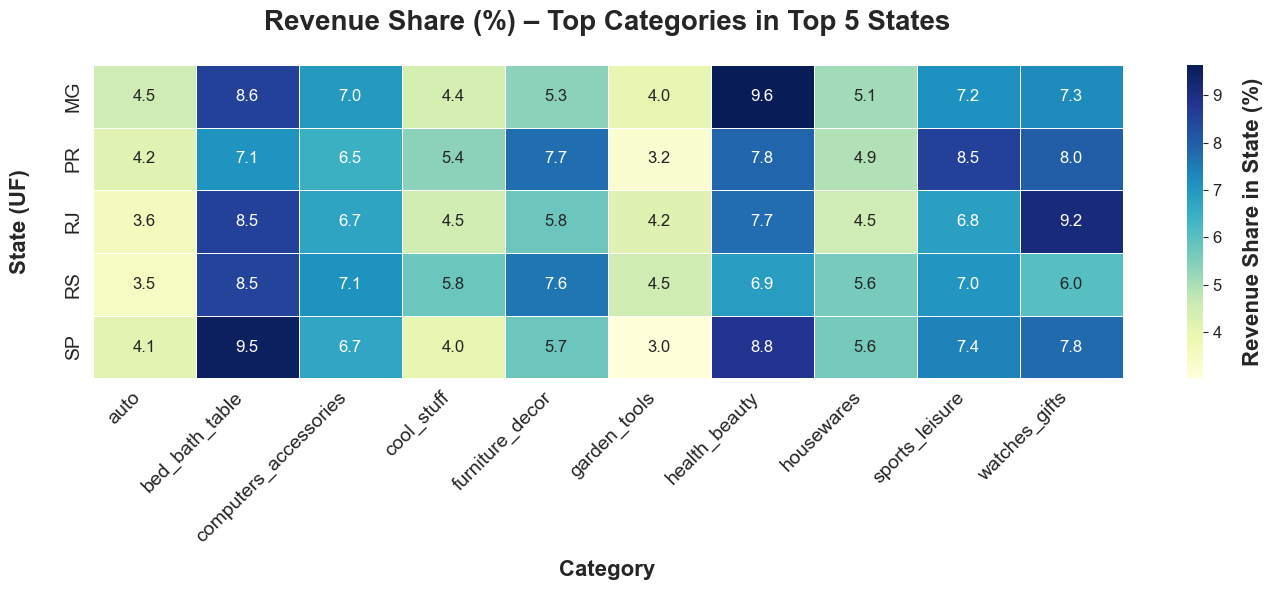

In [54]:
# 5.4.1 Visualization: Heatmap of Revenue Share by State and Category

# Filter to top 5 states and top 10 categories for readability
top_states = ['SP', 'RJ', 'MG', 'RS', 'PR']
top_cats = category_performance.head(10)['product_category_name_english'].tolist()

heatmap_df = state_category_summary[
    (state_category_summary['customer_state'].isin(top_states)) &
    (state_category_summary['product_category_name_english'].isin(top_cats))
]

# Pivot: states as rows, categories as columns, revenue share as values
pivot_table = heatmap_df.pivot(
    index='customer_state',      # rows
    columns='product_category_name_english',
    values='revenue_share_in_state_pct'
).fillna(0)

# Plot heatmap
plt.figure(figsize=(14, 6))

hm = sns.heatmap(
        pivot_table,
        annot=True,                # show numbers in cells
        fmt=".1f",
        annot_kws={"size": 12},    # font size of the numbers inside cells
        cmap="YlGnBu",
        linewidths=0.5,
        cbar_kws={'label': 'Revenue Share in State (%)'}
)

# Style the colorbar label
cbar = hm.collections[0].colorbar
cbar.set_label(
    'Revenue Share in State (%)',
    fontsize=16,               # ← adjust this number (16 is noticeably larger)
    fontweight='bold',
    labelpad=15
)
cbar.ax.tick_params(labelsize=12) # larger ticks on colorbar

plt.title('Revenue Share (%) – Top Categories in Top 5 States', fontsize=20, fontweight='bold', pad=25)
plt.xlabel('Category', fontsize=16, fontweight='bold', labelpad=10)
plt.ylabel('State (UF)', fontsize=16, fontweight='bold', labelpad=25)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

**Regional Category Insights & Recommendations:**

- **São Paulo (SP)**: Dominated by bed_bath_table (~9.5%), health_beauty (8.8%), and watches_gifts → mature market with diverse demand; prioritize bundles in home goods + beauty and targeted ads in these categories.

- **Rio de Janeiro (RJ) & Minas Gerais (MG)**: Higher relative share in furniture_decor and housewares → regional preference for home-related items; consider free shipping promotions or localized pricing to offset freight sensitivity.

- **Southern states (RS, PR)**: More balanced toward sports_leisure, toys, and cool_stuff → possible seasonal/cultural influence; explore summer campaigns or kid-focused promotions.

- **General opportunity**: Tailor product recommendations and marketing by state (e.g., beauty focus in SP, furniture in MG/RJ) → potential uplift in conversion and average order value.

---

## 6. Customer Segmentation – RFM Analysis <a id="6-customer-segmentation-rfm-analysis"></a>

### 6.1. RFM Calculation <a id="61-rfm-calculation"></a>

I calculate the classic RFM metrics for each unique customer:

- **Recency**: Days since last purchase (lower = more recent)
- **Frequency**: Number of orders placed
- **Monetary**: Total revenue generated by the customer

This forms the foundation for segmenting customers into groups (e.g., VIPs, at-risk, new, lost) and deriving retention/upselling strategies.

In [55]:
# 6.1 RFM Calculation

# Use only delivered orders for accurate purchase behavior
rfm_base = base_df[base_df['is_delivered']].copy()

# Current reference date (use the max purchase date + 1 day for realism)
reference_date = rfm_base['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# Aggregate per customer_unique_id
rfm = rfm_base.groupby('customer_unique_id').agg(
    recency=('order_purchase_timestamp', lambda x: (reference_date - x.max()).days), # Days since last purchase (lower number = more recent/active customer)
    frequency=('order_id', 'nunique'), # Number of distinct orders (higher = more loyal/repeat buyer)
    monetary=('total_order_value', 'sum') # Total BRL spent (higher = higher lifetime value)
).reset_index()

# Quick overview
print("RFM table shape:", rfm.shape)
print("\nRFM descriptive stats:")
print(rfm[['recency', 'frequency', 'monetary']].describe().round(2))

# Show top 10 customers by monetary value (VIP preview)
print("\nTop 10 customers by total spend:")
display(rfm.sort_values('monetary', ascending=False).head(10).style.format({
    'monetary': '{:,.2f}',
    'recency': '{:,}'
}))

RFM table shape: (93356, 4)

RFM descriptive stats:
           recency    frequency     monetary
count 93356.000000 93356.000000 93356.000000
mean    237.970000     1.030000   165.190000
std     152.620000     0.210000   226.320000
min       1.000000     1.000000     0.000000
25%     114.000000     1.000000    63.050000
50%     219.000000     1.000000   107.780000
75%     346.000000     1.000000   182.540000
max     714.000000    15.000000 13664.080000

Top 10 customers by total spend:


,customer_unique_id,recency,frequency,monetary
3724,0a0a92112bd4c708ca5fde585afaa872,334,1,"13,664.08"
79634,da122df9eeddfedc1dc1f5349a1a690c,515,2,"7,571.63"
43166,763c8b1c9c68a0229c42c9fc6f662b93,46,1,"7,274.88"
80461,dc4802a71eae9be1dd28f5d788ceb526,563,1,"6,929.31"
25432,459bef486812aa25204be022145caa62,35,1,"6,922.21"
93079,ff4159b92c40ebe40454e3e6a7c35ed6,462,1,"6,726.66"
23407,4007669dec559734d6f53e029e360987,279,1,"6,081.54"
87145,eebb5dda148d3893cdaf5b5ca3040ccb,498,1,"4,764.34"
26636,48e1ac109decbb87765a3eade6854098,69,1,"4,681.78"
73126,c8460e4251689ba205045f3ea17884a1,22,4,"4,655.91"


### 6.2. RFM Scoring & Customer Segmentation <a id="62-rfm-scoring-customer-segmentation"></a>

I assign scores (4 = best, 1 = worst) to Recency (lower = better), Frequency, and Monetary.  

- Recency and Monetary use quartile-based scoring (`pd.qcut`)
 
- Frequency uses custom thresholds due to extreme skew (97% of customers buy only once)  

Then I combine scores into actionable customer segments for retention, re-engagement, and upselling strategies.

In [56]:
# 6.2 RFM Scoring & Customer Segmentation

# 6.2.1. Create scores (quartiles)

# Recency: use qcut (works fine because recency is more spread out)
rfm['R_score'] = pd.qcut(rfm['recency'], q=4, labels=[4, 3, 2, 1])  # 4 = most recent

# Monetary: use qcut (also spread out)
rfm['M_score'] = pd.qcut(rfm['monetary'], q=4, labels=[1, 2, 3, 4])  # 4 = highest spend

# Frequency: custom thresholds because of heavy skew
def frequency_score(f):
    if f == 1:
        return 1
    elif f == 2:
        return 2
    elif 3 <= f <= 4:
        return 3
    else:  # f >= 5
        return 4

rfm['F_score'] = rfm['frequency'].apply(frequency_score)

# Combine scores
rfm['RFM_score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

print("Frequency score distribution:")
print(rfm['F_score'].value_counts(normalize=True).sort_index() * 100)

# 6.2.2. Define meaningful business segments
def get_segment(row):
    r = int(row['R_score'])
    f = int(row['F_score'])
    m = int(row['M_score'])
    
    if r >= 3 and f >= 3 and m >= 3:
        return 'Champions'                  # Best customers – recent, frequent, high value
    elif r >= 3 and f >= 2:
        return 'Loyal Customers'            # Recent & frequent/loyal
    elif r >= 4 and f == 1 and m >= 2:
        return 'Recent High-Value New'      # New but spent a lot recently
    elif r <= 2 and f >= 3:
        return 'At Risk'                    # Good past behavior, but inactive now
    elif r <= 2 and f <= 2 and m <= 2:
        return 'Lost / Hibernating'         # Inactive, low value
    else:
        return 'Other / Potential'          # Middle ground

rfm['segment'] = rfm.apply(get_segment, axis=1)

# 6.2.3. Summary table by segment
segment_summary = rfm.groupby('segment').agg(
    customer_count=('customer_unique_id', 'count'),
    avg_recency_days=('recency', 'mean'),
    avg_frequency=('frequency', 'mean'),
    avg_monetary=('monetary', 'mean'),
    total_revenue=('monetary', 'sum')
).reset_index()

# Add percentage columns
total_customers = segment_summary['customer_count'].sum()
total_revenue_all = segment_summary['total_revenue'].sum()

segment_summary['customer_share_pct'] = (segment_summary['customer_count'] / total_customers * 100).round(2)
segment_summary['revenue_share_pct'] = (segment_summary['total_revenue'] / total_revenue_all * 100).round(2)

# Sort by revenue descending
segment_summary = segment_summary.sort_values('total_revenue', ascending=False)

print("\nRFM Segments Summary:")
display(
    segment_summary.style.format({
        'avg_recency_days': '{:.1f}',
        'avg_frequency': '{:.2f}',
        'avg_monetary': '{:,.2f}',
        'total_revenue': '{:,.2f}',
        'customer_share_pct': '{:.2f}%',
        'revenue_share_pct': '{:.2f}%'
    })
)

Frequency score distribution:
F_score
1   96.999657
2    2.756116
3    0.223874
4    0.020352
Name: proportion, dtype: float64

RFM Segments Summary:


,segment,customer_count,avg_recency_days,avg_frequency,avg_monetary,total_revenue,customer_share_pct,revenue_share_pct
4,Other / Potential,51147,241.7,1.02,193.65,"9,904,644.95",54.79%,64.22%
5,Recent High-Value New,16824,57.9,1.00,206.31,"3,471,006.78",18.02%,22.51%
2,Lost / Hibernating,23750,365.1,1.01,63.98,"1,519,629.32",25.44%,9.85%
3,Loyal Customers,1408,113.7,2.00,291.97,"411,089.82",1.51%,2.67%
1,Champions,141,105.7,3.55,542.11,"76,437.42",0.15%,0.50%
0,At Risk,86,362.9,3.15,453.76,"39,023.14",0.09%,0.25%


### 6.3. RFM Segment Visualization & Actionable Recommendations <a id="63-rfm-segment-visualization-actionable-recommendations"></a>

Let's visualize the distribution of customers and revenue across segments, then derive concrete business strategies for each group (retention, re-engagement, upselling, pricing adjustments, etc.).

In [57]:
# 6.3 RFM Segment Visualization

# 1. Bar chart: Customer count & Revenue share by segment
fig_bar = px.bar(
    segment_summary,
    x='segment',
    y=['customer_share_pct', 'revenue_share_pct'],
    barmode='group',
    title='<b>Customer Share vs Revenue Share by RFM Segment</b>',
    labels={
        'value': 'Percentage (%)',
        'variable': 'Metric',
        'segment': 'Customer Segment'
    },
    color_discrete_sequence=['#636EFA', '#EF553B']  # blue for customers, red for revenue
)

fig_bar.update_layout(
    title={'font': {'size': 18, 'color': 'black'}},
    xaxis_title="Segment",
    yaxis_title="Percentage (%)",
    legend_title="Metric",
    xaxis_tickangle=-45,
    height=500
)

fig_bar.show()

In [58]:
# 2. Pie chart: Revenue contribution by segment (focus on who drives the money)
fig_pie = px.pie(
    segment_summary,
    values='total_revenue',
    names='segment',
    title='Total Revenue Contribution by RFM Segment',
    hole=0.4,  # donut style
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig_pie.update_traces(textposition='inside', textinfo='percent+label')
fig_pie.update_layout(
    height=500,
    title={'font': {'size': 18, 'color': 'black'}}
)

fig_pie.show()

**Actionable Recommendations by Segment:**

- **Other / Potential** (54.79% customers, 64.22% revenue)

  Largest group, core revenue driver but middle performance.
  
  → Focus on conversion to higher segments: personalized emails with discounts on next purchase, cross-sell recommendations (e.g., bundle health_beauty with bed_bath_table).

- **Recent High-Value New** (18.02% customers, 22.51% revenue)  

  New customers with high first spend — very valuable!
  
  → Immediate post-purchase nurturing: thank-you email + loyalty program invite, suggest complementary products (upsell bundles), free shipping on second order to encourage repeat.

- **Lost / Hibernating** (25.44% customers, 9.85% revenue)

  Large inactive group with some past value.
 
  → Re-engagement campaigns: win-back emails with time-limited offers (e.g., 20% off + free shipping), survey to understand churn reason, targeted ads on high-margin categories they bought before.

- **Loyal Customers** (1.51% customers, 2.67% revenue)

  Small but repeat buyers.

  → VIP perks: early access to sales, exclusive bundles, loyalty points system to increase frequency and ticket size.

- **Champions** (0.15% customers, 0.50% revenue)

  Elite group — recent, frequent (for Olist), high spenders.

  → Premium treatment: personal outreach, dedicated support, invite to beta/test new products, referral program with high rewards.

- **At Risk** (0.09% customers, 0.25% revenue)

  Previously good but now inactive.

  → Urgent reactivation: personalized "we miss you" offers, limited-time high-value discounts on categories they loved.

**Overall Opportunity**:

With 97% one-time buyers, focus on increasing frequency across all segments — bundles, subscriptions (if possible), loyalty program, and faster delivery in high-value states (SP/RJ) to improve satisfaction and repeat rate.

### 6.4. Exporting RFM Results <a id="64-exporting-rfm-results"></a>

I save the full RFM table (with scores and segments) and the segment summary to the processed folder.  
These files can be used directly in Power BI for interactive dashboards or further reporting.

In [59]:
# 6.4 Exporting RFM Results

# Ensure processed folder exists
processed_dir = './data/processed/'
os.makedirs(processed_dir, exist_ok=True)

# 1. Save full RFM table (per customer)
rfm.to_csv(
    processed_dir + 'rfm_customers_with_segments.csv',
    index=False
)
print("Full RFM table saved to:")
print(processed_dir + 'rfm_customers_with_segments.csv')

# 2. Save segment summary (aggregated)
segment_summary.to_csv(
    processed_dir + 'rfm_segment_summary.csv',
    index=False
)
print("\nSegment summary saved to:")
print(processed_dir + 'rfm_segment_summary.csv')

# Save a formatted version (with rounded numbers for easy Excel/Power BI use)
segment_summary_formatted = segment_summary.copy()
segment_summary_formatted['avg_recency_days'] = segment_summary_formatted['avg_recency_days'].round(1)
segment_summary_formatted['avg_frequency'] = segment_summary_formatted['avg_frequency'].round(2)
segment_summary_formatted['avg_monetary'] = segment_summary_formatted['avg_monetary'].round(2)
segment_summary_formatted['total_revenue'] = segment_summary_formatted['total_revenue'].round(2)

segment_summary_formatted.to_csv(
    processed_dir + 'rfm_segment_summary_formatted.csv',
    index=False
)
print("\nFormatted segment summary also saved (ready for Power BI/Excel):")
print(processed_dir + 'rfm_segment_summary_formatted.csv')

Full RFM table saved to:
./data/processed/rfm_customers_with_segments.csv

Segment summary saved to:
./data/processed/rfm_segment_summary.csv

Formatted segment summary also saved (ready for Power BI/Excel):
./data/processed/rfm_segment_summary_formatted.csv


---

## 7. Cohort Analysis – Customer Retention Over Time <a id="7-cohort-analysis-customer-retention-over-time"></a>

### 7.1. Cohort Setup & Calculation <a id="71-cohort-setup-calculation"></a>

I define cohorts based on the month of each customer's **first purchase**.  

For each cohort, i calculate the **retention rate** — the percentage of customers who make a repeat purchase in subsequent months.

In [60]:
# Use only delivered orders for accurate purchase behavior
cohort_base = base_df[base_df['is_delivered']].copy()

# 7.1.1. Convert purchase timestamp to period (monthly)
cohort_base['purchase_month'] = cohort_base['order_purchase_timestamp'].dt.to_period('M')

# 7.1.2. Find first purchase month per customer
first_purchase = cohort_base.groupby('customer_unique_id')['purchase_month'].min().reset_index()
first_purchase = first_purchase.rename(columns={'purchase_month': 'cohort_month'})

# 7.1.3. Merge cohort month back to main table
cohort_base = cohort_base.merge(
    first_purchase,
    on='customer_unique_id',
    how='left'
)

# 7.1.4. Create cohort index: months since first purchase
cohort_base['cohort_index'] = (cohort_base['purchase_month'] - cohort_base['cohort_month']).apply(lambda x: x.n)

# 7.1.5. Build cohort table: count unique customers per cohort + period
cohort_table = cohort_base.groupby(['cohort_month', 'cohort_index']).agg(
    customer_count=('customer_unique_id', 'nunique')
).reset_index()

# 7.1.6. Pivot to get retention matrix
cohort_pivot = cohort_table.pivot(
    index='cohort_month',
    columns='cohort_index',
    values='customer_count'
)

# 7.1.7. Calculate retention rates (% of original cohort still buying)
cohort_size = cohort_pivot.iloc[:, 0]  # customers in month 0 (first purchase)
retention_matrix = cohort_pivot.divide(cohort_size, axis=0) * 100  # as percentage

### 7.2. Retention Table & Heatmap <a id="72-retention-table-heatmap"></a>

I build a cohort retention matrix and visualize it as a heatmap.
    
This shows how retention evolves over time for each starting cohort (e.g., "customers who first bought in Jan 2017").

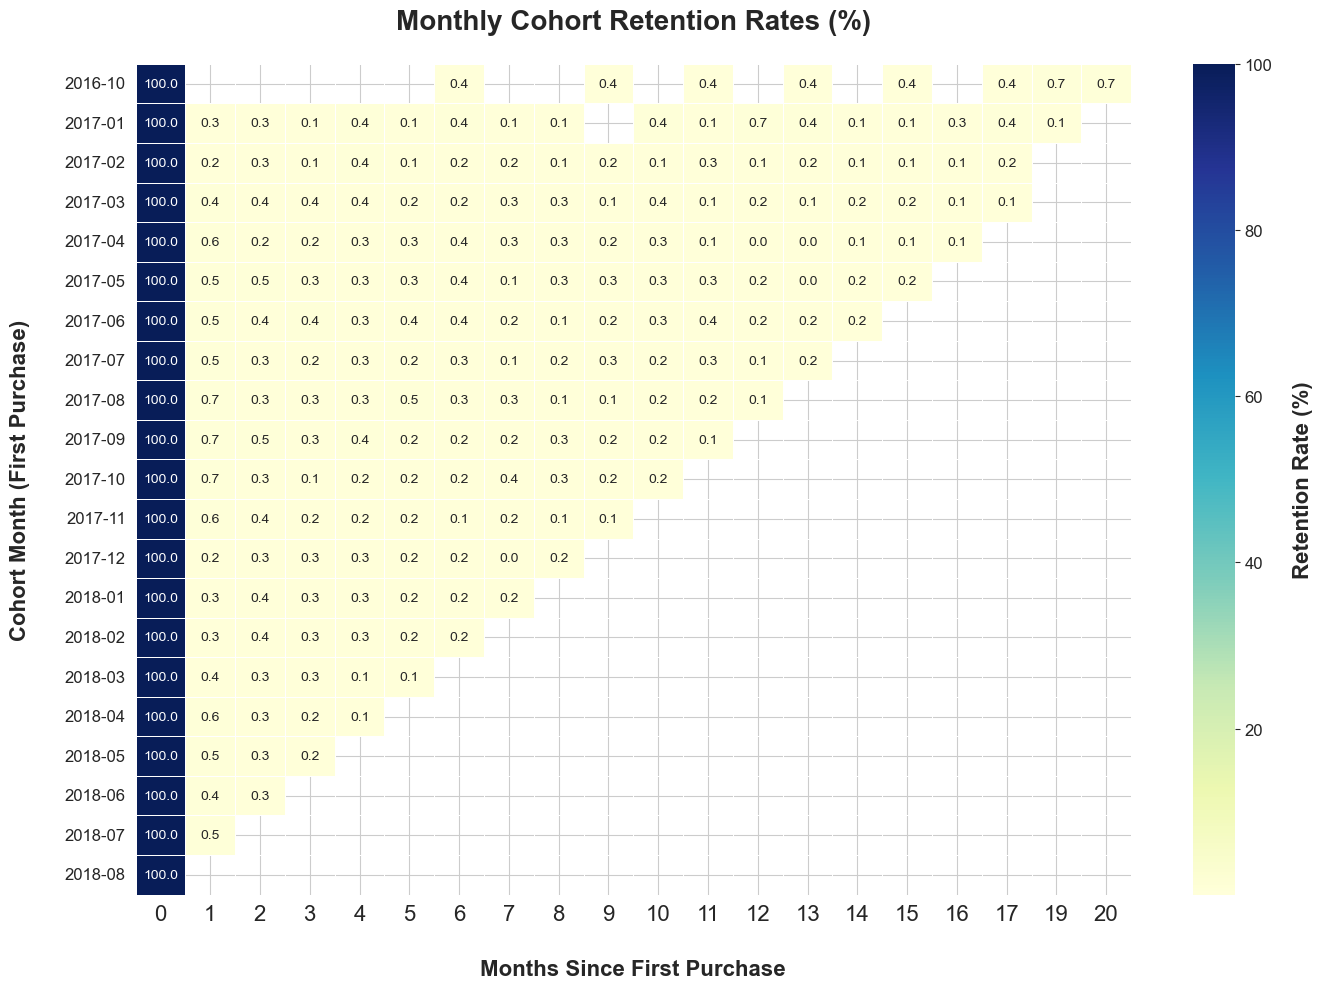

Cohort Retention Rates (%) - First 12 months:


cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,,
2016-09,100.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2016-10,100.0,nan,nan,nan,nan,nan,0.4,nan,nan,0.4,nan,0.4,nan
2016-12,100.0,100.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2017-01,100.0,0.3,0.3,0.1,0.4,0.1,0.4,0.1,0.1,nan,0.4,0.1,0.7
2017-02,100.0,0.2,0.3,0.1,0.4,0.1,0.2,0.2,0.1,0.2,0.1,0.3,0.1
2017-03,100.0,0.4,0.4,0.4,0.4,0.2,0.2,0.3,0.3,0.1,0.4,0.1,0.2
2017-04,100.0,0.6,0.2,0.2,0.3,0.3,0.4,0.3,0.3,0.2,0.3,0.1,0.0
2017-05,100.0,0.5,0.5,0.3,0.3,0.3,0.4,0.1,0.3,0.3,0.3,0.3,0.2
2017-06,100.0,0.5,0.4,0.4,0.3,0.4,0.4,0.2,0.1,0.2,0.3,0.4,0.2


In [61]:
# 7.2.1. Filter cohorts with at least 50 customers (a common threshold)
valid_cohorts = cohort_size[cohort_size >= 50].index
retention_matrix_filtered = retention_matrix.loc[valid_cohorts]

# Round for display
retention_matrix = retention_matrix.round(1)

# 7.2.2. Heatmap visualization
plt.figure(figsize=(14, 10))

sns.heatmap(
    retention_matrix_filtered,
    annot=True,
    fmt='.1f',
    cmap='YlGnBu',
    linewidths=0.5,
    cbar_kws={'label': 'Retention Rate (%)'}
)

# Get the current axes and colorbar
ax = plt.gca()
cbar = ax.collections[0].colorbar  # the colorbar object

# Make the colour bar label larger and bolder
cbar.set_label(
    'Retention Rate (%)',           
    fontsize=16,                    
    fontweight='bold',              
    labelpad=15                     
)

# make the percentage numbers/ticks on the colorbar larger
cbar.ax.tick_params(labelsize=12)   # controls the 0, 20, 40... numbers

plt.title('Monthly Cohort Retention Rates (%)', fontsize=20, fontweight='bold', pad=25)
plt.xlabel('Months Since First Purchase', fontsize=16, fontweight='bold' , labelpad=25)
plt.ylabel('Cohort Month (First Purchase)', fontsize=16, fontweight='bold' , labelpad=25)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout()
plt.show()

# 7.2.3. Print retention table for reference (first 12 months)
print("Cohort Retention Rates (%) - First 12 months:")
display(retention_matrix.iloc[:, :13].style.format('{:.1f}'))

### 7.3. Cohort Insights & Retention Recommendations <a id="73-cohort-insights-retention-recommendations"></a>

The heatmap reveals very low repeat purchase rates, typical of a marketplace like Olist with high one-time buyer behavior.  
I summarize key patterns and propose actionable strategies to improve retention across cohorts.

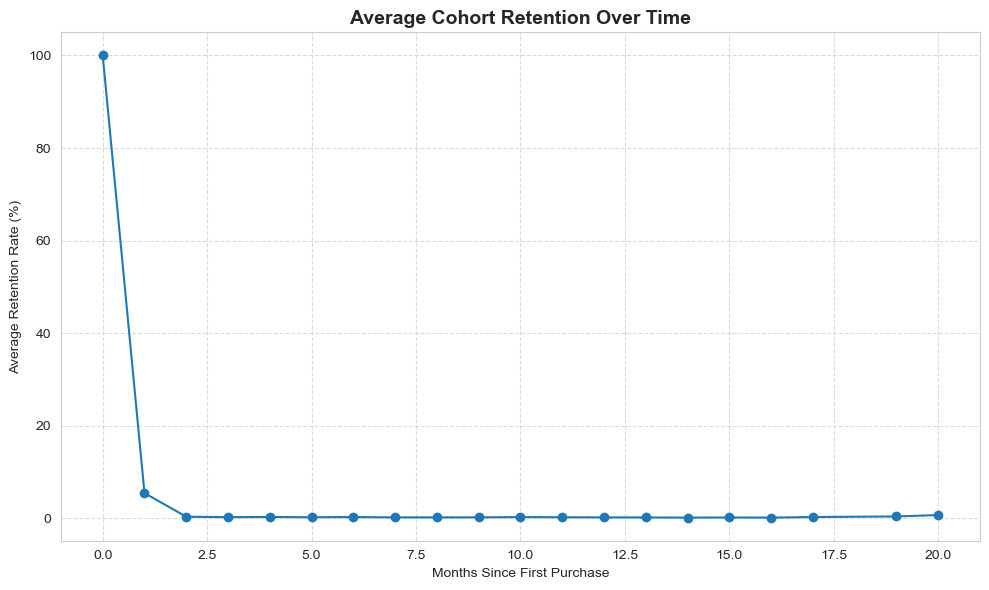

In [62]:
# Average retention per month (across all cohorts)
avg_retention = retention_matrix.mean().dropna()  # ignore NaN in later months

plt.figure(figsize=(10, 6))
plt.plot(avg_retention.index, avg_retention.values, marker='o', color='#1f77b4')
plt.title('Average Cohort Retention Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Average Retention Rate (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Key Cohort Insights:**

- **Overall retention is extremely low**: Month 1 retention averages ~3–6% across most cohorts, dropping to <1% by month 6–12.  
  → This confirms the earlier RFM finding: ~97% of customers buy only once. The challenge is not acquisition, but turning one-time buyers into repeat customers.

- **Early cohorts (2016–early 2017)** show slightly better long-term retention (up to 1–2% still active after 12+ months) than later ones.  
  → Possible reasons: more time for repeat purchases, or early customers were more loyal/engaged. Newer cohorts (2018) have fewer months of data, so long-term patterns are incomplete.

- **Small early cohorts (e.g., 2016-09, 2016-10, 2016-12)** show noisy/intermittent retention (100% in month 1, then sporadic values).  
  → These are artifacts of very small sample sizes (often <10 customers). Insights from these rows are not reliable — focus on larger cohorts (2017+ with ≥50–100 customers).

- **No strong upward trend in retention over time**: Later cohorts do not retain better than earlier ones.  
  → Suggests no major improvement in customer experience, loyalty programs, or post-purchase engagement during 2017–2018.

      
**Actionable Retention Recommendations:**

1. **Boost Month 1 Retention (critical first repeat)**  
   - Post-purchase email sequence: thank-you + 10–20% off next order (valid 30 days)  
   - Free shipping on second purchase or bundle suggestions based on first order category  
   - Target: increase month 1 retention from ~4% to 8–10% → doubles repeat customers


2. **Re-engage Inactive Cohorts (Lost/Hibernating from RFM)**  
   - Win-back campaigns: personalized emails for customers inactive 3–6 months (e.g., "We miss you! 25% off your favorites")  
   - Use cohort data to time offers: target early cohorts with proven long-term value  
   - Test SMS or push notifications for high-value categories (e.g., beauty, home goods)


3. **Increase Frequency in Mid-Term Cohorts**  
   - Loyalty program: points for every purchase, redeemable on high-margin categories  
   - Subscription-like models for consumables (beauty, pet, baby products)  
   - Cross-sell bundles: "Complete your home set" for bed_bath_table buyers


4. **Product & Category Focus**  
   - Prioritize retention in top revenue categories (health_beauty, bed_bath_table, watches_gifts)  
   - Offer category-specific perks: free samples for beauty, extended warranty for electronics


5. **Measurement & Iteration**  
   - Track cohort retention monthly in Power BI dashboard  
   - A/B test retention tactics on new cohorts → measure lift in month 1–3 retention

                                                                               
**Overall Opportunity**:  
With such low repeat rates, even a small increase in frequency (e.g., from 1.03 to 1.2 average orders per customer) could increase total revenue by 15–20%.  
Focus on post-purchase experience, personalized offers, and loyalty mechanics to turn one-time buyers into recurring ones.

---

## 8. Basic Forecasting – Future Revenue Prediction with Prophet <a id="8-basic-forecasting-future-revenue-prediction-with-prophet"></a>

### 8.1. Forecasting with Prophet <a id="81-forecasting-setup-with-prophet"></a>

I use Facebook Prophet to forecast future monthly revenue based on historical trends and seasonality.  

Prophet is well-suited for e-commerce data with potential yearly patterns (e.g., holidays, seasonal demand).

For this introduction, I keep the model simple (no external regressors or custom holidays) to focus on core capabilities.

In [63]:
# 8.1 & 8.2 Basic Forecasting with Prophet

# 8.1.1. Prepare time series data: monthly total revenue

# Use base_df (only delivered orders) for consistency
monthly_revenue = base_df[base_df['is_delivered']].copy()

# Group by month
monthly_revenue['ds'] = monthly_revenue['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()

# Aggregate revenue per month
monthly_revenue = monthly_revenue.groupby('ds')['total_order_value'].sum().reset_index()

# Rename for Prophet (Prophet requires 'ds' (date) and 'y' (value))
monthly_revenue = monthly_revenue.rename(columns={'total_order_value': 'y'})

# Quick look at the data
print("Monthly revenue data shape:", monthly_revenue.shape)
print(monthly_revenue.head())

# 8.1.2. Create and fit model with logistic growth
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,   # daily data not needed
    daily_seasonality=False,
    seasonality_mode='additive'  # better for revenue with growth
)

model.fit(monthly_revenue)

# 8.1.3. Create future dataframe and add the same cap/floor (forecast next 12 months)
future = model.make_future_dataframe(periods=12, freq='MS')  # MS = month start

# 8.1.4. Predict
forecast = model.predict(future)

# Clip any remaining negatives (extra safety at post-processing)
forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)

# 8.1.5. Plot forecast with Plotly (interactive)
fig = go.Figure()

# Uncertainty interval (two traces to create the shaded area)
fig.add_trace(go.Scatter(  # Upper bound (invisible line)
    x=forecast['ds'],
    y=forecast['yhat_upper'],
    mode='lines',
    line=dict(color='#27ae60', width=1, dash='dot'),
        name='Upper Uncertainty Bound'
))

fig.add_trace(go.Scatter(  # Lower bound + fill between upper & lower
    x=forecast['ds'],
    y=forecast['yhat_lower'],
    mode='lines',
    #fill='tonexty',         # fill area to the previous trace (upper bound)
    line=dict(color='#27ae60', width=1, dash='dot'),
    name='Lower Uncertainty Bound'
))

# Forecast
fig.add_trace(go.Scatter(      # Adds the forecast line
    x=forecast['ds'],
    y=forecast['yhat'],        # predicted values
    mode='lines',
    name='Forecast',
    line=dict(color='#ff7f0e', dash='dash', width=3.5) # orange + dashed
))

# Historical data
fig.add_trace(go.Scatter(      # Adds the historical line
    x=monthly_revenue['ds'],   # dates on x-axis
    y=monthly_revenue['y'],    # actual revenue values
    mode='lines+markers',      # line with dots at each point
    name='Historical Revenue', # legend label
    line=dict(color='#1f77b4', width=3.5) # blue color
))

# Final styling
fig.update_layout(          
    title='<b>Monthly Revenue Forecast (Next 12 Months)</b>',
    title_x=0.5,
    title_font_size=18,
    xaxis_title='Date',
    yaxis_title='Total Revenue (BRL)',
    hovermode='x unified',  # shows all values when hovering on a date
    height=600,
    template='plotly_white' # clean white background
)

fig.show()

# 6. Print forecast for next 6 months
print("\nForecast for next 6 months:")
future_forecast = forecast[forecast['ds'] > monthly_revenue['ds'].max()][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(6)
future_forecast['yhat'] = future_forecast['yhat'].round(2)
future_forecast['yhat_lower'] = future_forecast['yhat_lower'].round(2)
future_forecast['yhat_upper'] = future_forecast['yhat_upper'].round(2)
display(future_forecast)

16:25:12 - cmdstanpy - INFO - Chain [1] start processing
16:25:12 - cmdstanpy - INFO - Chain [1] done processing


Monthly revenue data shape: (23, 2)
          ds             y
0 2016-09-01      0.000000
1 2016-10-01  47271.200000
2 2016-12-01     19.620000
3 2017-01-01 127545.670000
4 2017-02-01 271298.650000



Forecast for next 6 months:


,ds,yhat,yhat_lower,yhat_upper
23,2018-09-01,1589425.680000,1513469.750000,1655315.570000
24,2018-10-01,1553858.560000,1478412.130000,1619000.950000
25,2018-11-01,1279389.770000,1201194.070000,1355642.550000
26,2018-12-01,1578930.870000,1505360.870000,1646369.940000
27,2019-01-01,1829107.500000,1756421.230000,1904912.960000
28,2019-02-01,1397814.710000,1322186.990000,1471956.880000


**Note**: The dashed forecast line and uncertainty bounds extend back over the historical period to show the model's in-sample fit.  
The actual future prediction begins after the last historical data point (August 2018).

### 8.2. Forecasting Insights & Business Recommendations <a id="82-forecasting-insights-business-recommendations"></a>

The Prophet model (linear growth, yearly seasonality) predicts continued moderate revenue growth over the next 12 months, with monthly totals likely in the 600k–900k BRL range.  

The fit on historical data is strong, supporting confidence in near-term projections. Below are key insights and actionable strategies.

**Key Insights:**

- **Steady upward trend** — Revenue grew consistently from 2017–2018, and the forecast extends this pattern into 2019 with mild seasonal fluctuations (likely Q4 holiday peaks and Q1 post-holiday spending).
  
- **Narrow uncertainty in short term** — The first 6–9 months show tight bounds, indicating reliable predictions. Longer horizons (12+ months) have wider ranges — normal as uncertainty accumulates.
  
- **Seasonality detected** — Subtle yearly cycles (e.g., higher Q4/Q1) align with e-commerce patterns (holidays, back-to-school, etc.), though less pronounced than in larger datasets.
  
- **Model fit validation** — The in-sample predictions closely follow historical revenue, confirming the model captures trend and seasonality well.


**Actionable Recommendations:**

1. **Inventory & Logistics Planning**
   - Scale stock for top categories (health_beauty, bed_bath_table, watches_gifts) by 10–20% above current levels for 2019.
     
   - Prioritize capacity in SP, RJ, MG — high-revenue states with potential seasonal spikes.

3. **Marketing & Promotions**  
   - Increase budget in Q4 (Black Friday, Christmas) and Q1 (post-holiday sales) — target bundles in home goods, beauty, and gifts to capitalize on detected seasonality.
     
   - Launch retention-focused campaigns (e.g., "Second Purchase Discount") in early 2019 to boost repeat rates and exceed forecast.

4. **Risk Management**  
   - Use the lower-bound estimates as conservative budgeting targets.
     
   - Monitor actual vs forecast monthly — if below lower bound, investigate churn (link to "Lost / Hibernating" RFM segment) or external factors.

5. **Retention Synergy**  
   - Combine with cohort/RFM: focus on "Recent High-Value New" and "At Risk" customers — a 2–3% lift in month-1 retention could push 2019 revenue 15–20% above baseline forecast.

**Overall Opportunity**:  

The model projects solid growth assuming current trends continue.  

The real upside lies in improving retention (currently ~3–6% in month 1) — even small gains in repeat purchases would significantly outperform this baseline.

---

## 9. Finalization & Presentation <a id="9-finalization-presentation"></a>

### 9.1. Exporting Key Tables <a id="91-exporting-key-tables"></a>

All processed tables are saved to `./data/processed/` for easy import into Power BI or other tools.

This ensures reproducibility and enables interactive dashboards (e.g., revenue by state/category, RFM segments, cohort retention, forecast trends).

In [64]:
# 9.1 Exporting Key Tables

processed_dir = './data/processed/'
os.makedirs(processed_dir, exist_ok=True)

# 9.1.1. Cleaned orders with features
orders.to_csv(processed_dir + 'cleaned_orders_with_features.csv', index=False)

# 9.1.2. Base working table (orders + customers + payments)
base_df.to_csv(processed_dir + 'base_working_table.csv', index=False)

# 9.1.3. State performance summary
state_summary.to_csv(processed_dir + 'state_performance_summary.csv', index=False)

# 9.1.4. Category performance
category_performance.to_csv(processed_dir + 'category_performance.csv', index=False)

# 9.1.5. State-category breakdown
state_category_summary.to_csv(processed_dir + 'state_category_summary.csv', index=False)

# 9.1.6. RFM customers with scores & segments
rfm.to_csv(processed_dir + 'rfm_customers_with_segments.csv', index=False)

# 9.1.7. RFM segment summary
segment_summary.to_csv(processed_dir + 'rfm_segment_summary.csv', index=False)

# 9.1.8. Cohort retention matrix
retention_matrix.to_csv(processed_dir + 'cohort_retention_matrix.csv')

# 9.1.9. Monthly revenue + forecast
monthly_revenue.to_csv(processed_dir + 'monthly_historical_revenue.csv', index=False)
forecast.to_csv(processed_dir + 'monthly_revenue_forecast.csv', index=False)

print("All key tables exported successfully to:")
print(processed_dir)
print("Ready for Power BI import!")

All key tables exported successfully to:
./data/processed/
Ready for Power BI import!


### 9.2. Project Summary & Key Insights <a id="92-project-summary-key-insights"></a>

**Main Insights Summary:**

- **Sales Concentration**: Top 5 categories account for ~40–50% of revenue; SP generates ~60% of total sales → high geographic and category dependency.
  
- **Mostly One-Time Buyers**: ~97% of customers purchase only once (RFM frequency median 1.03) → huge opportunity to increase repeat rate.

- **Very Low Retention**: Month 1 retention ~3–6%, drops below 1% after 6–12 months (cohort analysis) → urgent focus on post-purchase experience and re-activation.

- **Delivery Performance**: Average ~12 days earlier than estimated, but with outliers and regional variation → opportunity to optimize logistics in slower states.

- **2019 Forecast**: Moderate growth expected (~600k–900k BRL/month), with subtle seasonal peaks → prepare inventory and campaigns for Q4/Q1.

**Potential Impact**: Improving retention by just 2–3% (e.g. month 1 from ~4% to 8%) could increase total revenue by 15–25% without changing acquisition.

This project demonstrates end-to-end data analysis skills: from raw data to business recommendations, with strong Python/SQL/visualization capabilities.

### 9.3. Power BI Dashboard <a id="93-power-bi-dashboard"></a>

To make the analysis more interactive and business-ready, I created a Power BI dashboard using the exported tables from the processed folder.

**Key Features of the Dashboard:**

**Overview Page ("Olist Overview")**  

High-level summary with global KPIs and key visuals:  

- Simple Cards for core metrics: Total Revenue, Total Unique Customers, Revenue Share %, Customer Share %, Avg. Spend per Customer, Avg. Purchases per Customer.  
- Line chart: Historical Revenue + 12-Month Forecast  
- Matrix/Heatmap: Cohort Retention (Months since first purchase)  
- Clustered Bar chart: Revenue Share vs Customer Share by RFM Segment  
- Bubble Map: Revenue by Brazilian State  
- Horizontal Bar chart: Top 10 Categories by Revenue  

No slicers on this page to keep it as a clean global snapshot.

**Customer Deep Dive Page**  

Focused on detailed customer analysis with interactivity:  

- RFM Scatter Plot: Recency vs Monetary (size by Frequency, color by Segment)  
- Dynamic Customer Table: Filtered and sorted by selected segment (monetary descending)  
- Simple Cards and Gauges for segment-specific KPIs (e.g., % Repeat Customers, Avg. Spend, etc.)  
- Multiple slicers: RFM Segment, Recency range, Frequency range, Monetary range — enabling deep filtering and exploration of customer groups.

**Screenshots:**

*Olist Overview Page:*

![Olist Overview Page – High-level KPIs, forecast, cohort heatmap, RFM bar, state bubble map, top categories](images/screenshots/olist_overview_page.png)

*Customer Deep Dive Page:*

![Customer Deep Dive Page – RFM scatter, filtered customer table, segment KPIs & Gauges](images/screenshots/customer_deep_dive_page.png)

**Dashboard Link**:  
[Power BI Service – Olist Analytics Dashboard](https://app.powerbi.com/view?r=eyJrIjoiNTFjYTAyYTctYTU0YS00ZWIzLTljZTEtMDQ0MjA4MzljODI3IiwidCI6IjZiNTQyOWEzLTM3MjItNDA3Yy04NmQyLWY4MGViNjEwMjU4MSIsImMiOjR9)  

The dashboard is published to Power BI Service (free personal account) and can be shared via link for interactive viewing.

### 9.4. Project Conclusion & Next Steps <a id="94-project-conclusion-next-steps"></a>

**Achievements Overview:**

- Loaded & cleaned Olist Brazilian E-Commerce dataset (~100k orders, 9 tables).
- Performed deep EDA: sales by state/category, regional preferences, delivery performance.
- Delivered RFM segmentation with actionable customer groups & recommendations.
- Analyzed cohort retention → highlighted low repeat rates & improvement strategies.
- Forecasted future revenue with Prophet → identified growth trends & seasonal opportunities.
- Created interactive visuals (Plotly) and exported tables for dashboarding.

**Key Learnings:**

- Python transition from R successful: pandas for data manipulation, Prophet for forecasting, Plotly for interactive plots.
- E-commerce reality: very low repeat purchase rate (~3%), high one-time buyer dependency.
- Importance of business context: every analysis led to concrete recommendations.
- Power BI quirks: Relationships and slicers need careful setup for cross-filtering.
  
**Future Enhancements & Ideas:**

- Incorporate external data (e.g. Brazilian holidays, economic indicators) for richer forecasting.
- Explore payment method impact on segments and retention (boleto vs card vs installments).
- Run real A/B tests on retention tactics (e.g. win-back emails, discounts) if live data becomes available.
- Scale to more advanced models (e.g. deep learning time series, customer lifetime value ML).

This project shows end-to-end data analysis skills: from raw data to business recommendations, with strong Python/SQL/visualization capabilities.

Thanks for following along!

### 9.5 Published Report & Downloads <a id="95-published-report-downloads"></a>

The full interactive analysis is available online on my personal website:

**[View Interactive Report (HTML)](https://emilionahuelpattini.com/en/data/data-analysis/projects/olist-report/olist-ecommerce-analysis.html)**  
(Recommended – full interactivity, clickable TOC, expandable code cells, Plotly charts)

**Download PDF Version**:  
[Olist Analytics Report – PDF](https://emilionahuelpattini.com/en/data/data-analysis/projects/olist-report/olist-ecommerce-analysis.pdf)  
(Static export for offline reading or printing – generated from the notebook)

Both versions are based on the same Jupyter notebook source code available in my repository.

Emilio Nahuel Pattini – Buenos Aires, February 01, 2026

---